In [1]:
%matplotlib inline
import os
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange, tqdm

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import lightgbm as lgb

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats

from fastai.datasets import Config

import warnings
warnings.filterwarnings("ignore")

base_path = Config.data_path()

# Competiton files setup

In [2]:
data_path = base_path/'LANL_Earthquake_Prediction'
competition_name = 'LANL-Earthquake-Prediction'
data_path.mkdir(parents=True, exist_ok=True)
data_path

PosixPath('/home/jupyter/.fastai/data/LANL_Earthquake_Prediction')

In [3]:
!kaggle competitions files -c {competition_name}

name                    size  creationDate         
---------------------  -----  -------------------  
sample_submission.csv   33KB  2019-01-10 00:55:34  
test.zip               242MB  2019-01-10 00:55:46  
train.csv                9GB  2019-01-10 01:00:05  


In [5]:
!kaggle competitions download -c {competition_name} -p {data_path}

  0%|                                               | 0.00/33.3k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 33.3k/33.3k [00:00<00:00, 24.8MB/s]
 93%|██████████████████████████████████████   | 225M/242M [00:02<00:00, 111MB/s]
100%|█████████████████████████████████████████| 242M/242M [00:02<00:00, 114MB/s]
100%|█████████████████████████████████████▉| 2.02G/2.03G [00:27<00:00, 98.4MB/s]
100%|██████████████████████████████████████| 2.03G/2.03G [00:27<00:00, 79.7MB/s]


In [5]:
data_path.ls()

[PosixPath('/home/jupyter/.fastai/data/LANL_Earthquake_Prediction/test'),
 PosixPath('/home/jupyter/.fastai/data/LANL_Earthquake_Prediction/train.csv'),
 PosixPath('/home/jupyter/.fastai/data/LANL_Earthquake_Prediction/sample_submission.csv')]

In [9]:
from zipfile import ZipFile

file_name = "train.csv.zip"
print(f"Unziping {file_name} ...")
with ZipFile(data_path/file_name, 'r') as zip_ref:
    zip_ref.extractall(data_path)

os.remove(data_path/file_name)
print("Done")

file_name = "test.zip"
print(f"Unziping {file_name} ...")
test_files_destination = data_path/'test'
test_files_destination.mkdir()
with ZipFile(data_path/file_name, 'r') as zip_ref:
    zip_ref.extractall(test_files_destination)

os.remove(data_path/file_name)
print("Done")

Unziping train.csv.zip ...
Done
Unziping test.zip ...
Done


# Experiments with dataset

In [3]:
%%time
# Load training samples
df_train_original = pd.read_csv(
    data_path/'train.csv', 
    dtype={
        'acoustic_data': np.int16, 
        'time_to_failure': np.float64
    })

df_train_original.head()

CPU times: user 1min 46s, sys: 15.5 s, total: 2min 1s
Wall time: 2min


In [20]:
df_train_compressed = df_train_original.iloc[::10]

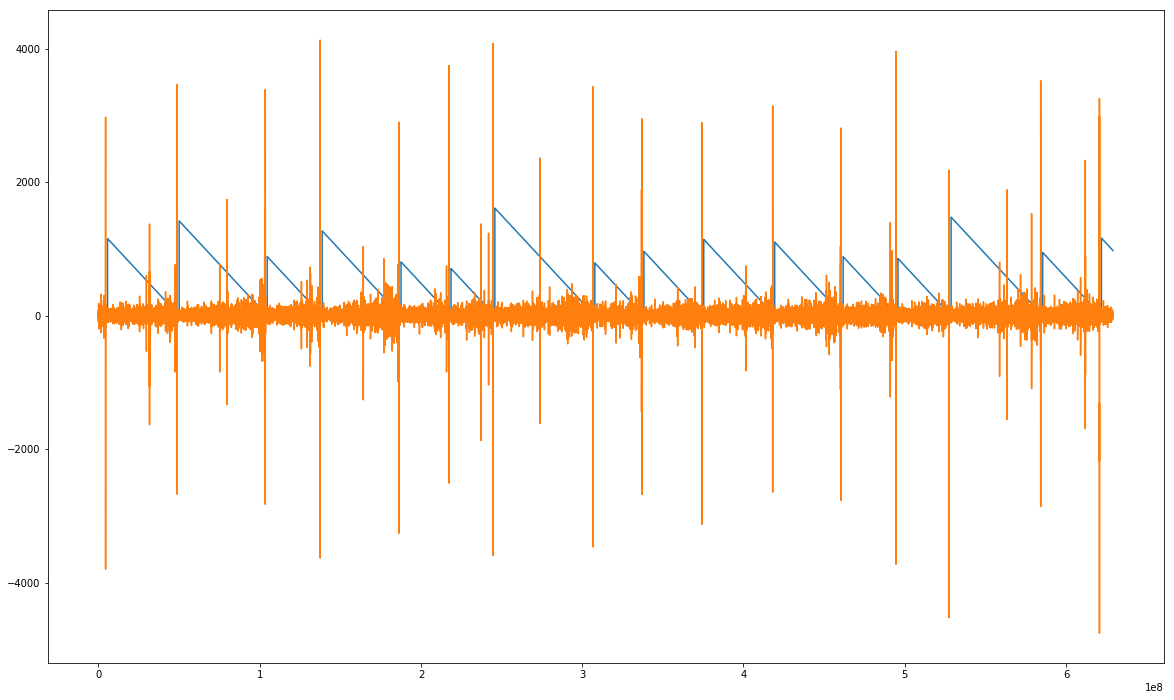

In [21]:
plt.figure(figsize=(20,12))
plt.plot(df_train_compressed.time_to_failure * 100)
plt.plot(df_train_compressed.acoustic_data)

In [4]:
# Load test samples
from collections import defaultdict

test_segments_lengths = defaultdict(int)
test_segments = list()
test_data_path = data_path/'test'

for segment_name in tqdm(test_data_path.ls()):
    segment_df = pd.read_csv(
        data_path/segment_name,
        dtype={'acoustic_data': np.int16}
    )
    test_segments.append(segment_df)
    segment_length = len(segment_df)
    test_segments_lengths[segment_length] += 1
    
print(test_segments_lengths)
print(f"Number of test samples: {len(test_segments)}")

100%|██████████| 2624/2624 [00:54<00:00, 47.92it/s]

defaultdict(<class 'int'>, {150000: 2624})
Number of test samples: 2624


In [5]:
# Get earthquake samples
quake_samples = df_train_original.loc[np.diff(df_train_original.time_to_failure.values) > 5]
print(f"Nbr of quakes found in training signal: {len(quake_samples)}")

Nbr of quakes found in training signal: 16


In [6]:
# Cut training signal into segments with length equal to test seqments
def is_quake_segment(start_idx, end_idx):
    for quake_idx in quake_samples.index:
        if start_idx < quake_idx and end_idx > quake_idx:
            return True
    
    return False

def cut_train_set_to_segments(step_between_segments):
    """
    If step_between_segments >= len(test_segment), segments will no overlapp
    """
    target_segment_length = len(test_segments[0])
    training_segments = list()
    training_quake_segments = list()
    amplitude_peak_segments = list()
    segment_start_idx = 0
    segment_end_idx = target_segment_length
    segments_created = 0

    while segment_end_idx < len(df_train_original):
        segment_candidate = df_train_original.iloc[segment_start_idx : segment_end_idx]

        if is_quake_segment(segment_start_idx, segment_end_idx):
            training_quake_segments.append(segment_candidate)
            # Amplitude peaks and minimum time to quake are not appearing in the same moment
            # By trial/error method I found that amplitude peaks occur ~8 segments before quake time minimum
            # Why?
            amplitude_peak_segments.append(training_segments[-8])
        else:
            training_segments.append(segment_candidate)

        segment_start_idx += step_between_segments
        segment_end_idx += step_between_segments
        segments_created += 1

        if not segments_created % 1000:
            print(f"Current segments count: {segments_created}...")

    print("Done")
    print(f"# of training segments: {len(training_segments)}")
    print(f"# of quake segments (will not be incuded in training): {len(training_quake_segments)}")
    
    return training_segments, training_quake_segments

In [68]:
training_segments_no_overlap, training_quake_segments = cut_train_set_to_segments(len(test_segments[0]))

Current segments count: 1000...
Current segments count: 2000...
Current segments count: 3000...
Current segments count: 4000...
Done
# of training segments: 4178
# of quake segments (will not be incuded in training): 16


In [8]:
training_segments_10000, training_quake_segments_10000 = cut_train_set_to_segments(10000)
# del training_segments_100

Current segments count: 1000...
Current segments count: 2000...
Current segments count: 3000...
Current segments count: 4000...
Current segments count: 5000...
Current segments count: 6000...
Current segments count: 7000...
Current segments count: 8000...
Current segments count: 9000...
Current segments count: 10000...
Current segments count: 11000...
Current segments count: 12000...
Current segments count: 13000...
Current segments count: 14000...
Current segments count: 15000...
Current segments count: 16000...
Current segments count: 17000...
Current segments count: 18000...
Current segments count: 19000...
Current segments count: 20000...
Current segments count: 21000...
Current segments count: 22000...
Current segments count: 23000...
Current segments count: 24000...
Current segments count: 25000...
Current segments count: 26000...
Current segments count: 27000...
Current segments count: 28000...
Current segments count: 29000...
Current segments count: 30000...
Current segments co

In [22]:
def save_train_segments(list_of_segments, folder_name):
    destination_folder = data_path/'train'/folder_name
    destination_folder.mkdir()
    
    for idx, segment in enumerate(tqdm(list_of_segments)):
        target_file = destination_folder/f'segment_{idx}.csv'
        segment.to_csv(target_file, index=False)

save_train_segments(training_segments_no_overlap, 'no_overlap')

100%|██████████| 4178/4178 [26:22<00:00,  2.80it/s]


In [10]:
def load_train_segments(folder_name, limit=None):
    segments_folder = data_path/'train'/folder_name
    
    # segments are not sorted for now!
    segment_names = segments_folder.ls()
    
    if limit is not None:
        segment_names = segment_names[:limit]
        
    segments = list()
    
    for segment_name in tqdm(segment_names):
        segment = pd.read_csv(
            segments_folder/segment_name,
               dtype={
                'acoustic_data': np.int16, 
                'time_to_failure': np.float64
                }
        )
        segments.append(segment)
    
    return segments

# train_segments_no_overlap = load_train_segments('no_overlap')

In [11]:
train_segments_no_overlap_small = load_train_segments('no_overlap', limit=2)

100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


In [12]:
train_segments_no_overlap_small[1].head()

,acoustic_data,time_to_failure
0,8,8.553996
1,5,8.553996
2,5,8.553996
3,3,8.553996
4,4,8.553996


In [10]:
a = train_segments_no_overlap_small[0].time_to_failure.values[1] - train_segments_no_overlap_small[0].time_to_failure.values[0]

In [36]:
train_segments_no_overlap_small[0].time_to_failure.values[1]

NameError: name 'train_segments_no_overlap_small' is not defined

In [15]:
format(df_train_original.time_to_failure.values[1], '.14g')

'1.4690999821'

In [16]:
format(df_train_original.time_to_failure.values[0], '.14g')

'1.4690999832'

In [30]:
time_step = df_train_original.time_to_failure.values[1] - df_train_original.time_to_failure.values[0]
sample_freq = 1/time_step
sample_freq

-909091017.3803408

In [31]:
time_step

-1.0999998689698032e-09

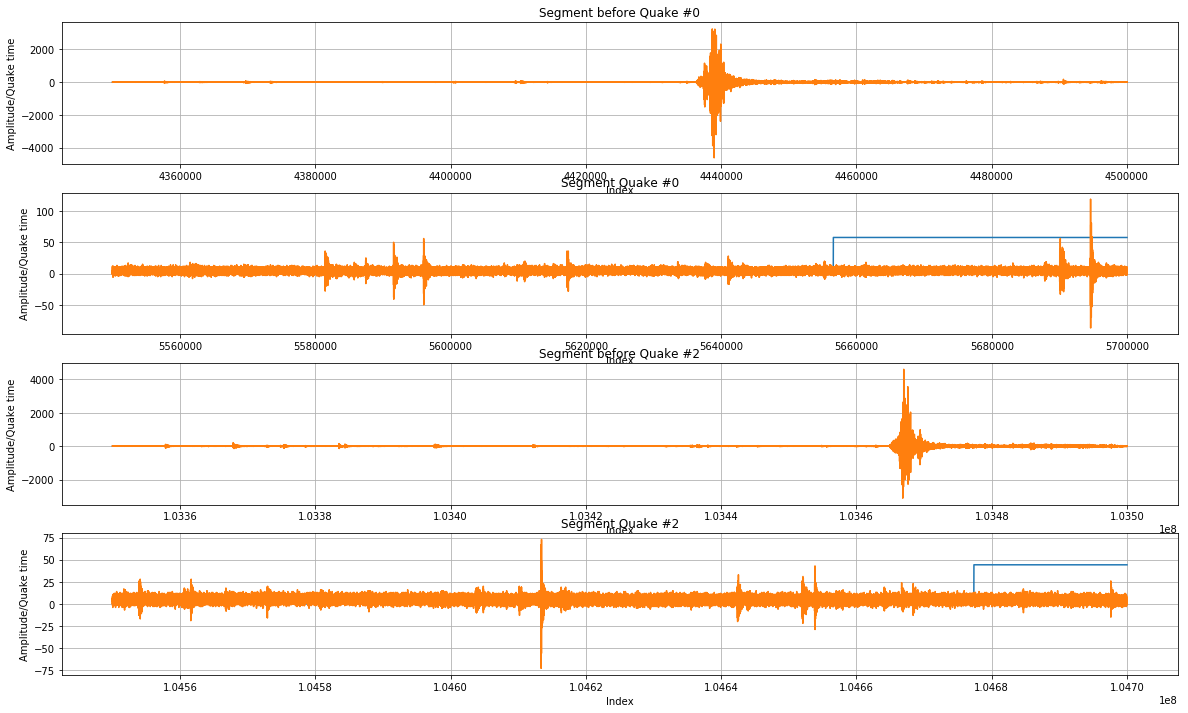

In [72]:
# Display quake segments
nbr_of_quake_segments_to_display = 2
fig, ax = plt.subplots(2 * nbr_of_quake_segments_to_display, 1, figsize=(20,12))

for idx in range(2 * nbr_of_quake_segments_to_display)[::2]:
    ax[idx].plot(amplitude_peak_segments[idx].time_to_failure * 5)
    ax[idx].plot(amplitude_peak_segments[idx].acoustic_data)
    ax[idx].set_title(f"Amplitude peak before Quake #{idx}")
    ax[idx].set_xlabel("Index")
    ax[idx].set_ylabel("Amplitude/Quake time")
    ax[idx].grid()
    ax[idx + 1].plot(training_quake_segments[idx].time_to_failure * 5)
    ax[idx + 1].plot(training_quake_segments[idx].acoustic_data)
    ax[idx + 1].set_title(f"Segment Quake #{idx}")
    ax[idx + 1].set_xlabel("Index")
    ax[idx + 1].set_ylabel("Amplitude/Quake time")
    ax[idx + 1].grid()


In [19]:
df_train_samall.iloc[quake_sample.index + 1]

,acoustic_data,time_to_failure
5656574,4,11.5408


In [19]:
# Detect amplitude peaks in train segments

amplitude_peaks = list()

for train_segment in tqdm(train_segments_no_overlap):
    amplitude_peaks.append(train_segment['acoustic_data'].max())

print(f"Max 5 amplitude peaks within test segments: {sorted(amplitude_peaks, reverse=True)[:5]}")

100%|██████████| 4178/4178 [00:02<00:00, 1643.96it/s]

Max 5 amplitude peaks within test segments: [5444, 5115, 4886, 4610, 4317]


In [20]:
# Detect amplitude peaks in test segments

amplitude_peaks = list()

for test_segment in tqdm(test_segments):
    amplitude_peaks.append(test_segment['acoustic_data'].max())

print(f"Max 5 amplitude peaks within test segments: {sorted(amplitude_peaks, reverse=True)[:5]}")

100%|██████████| 2624/2624 [00:01<00:00, 1999.99it/s]

Max 5 amplitude peaks within test segments: [6741, 4794, 4400, 4020, 3966]


In [23]:
df_train_samall = df_train_original.iloc[:10000000]

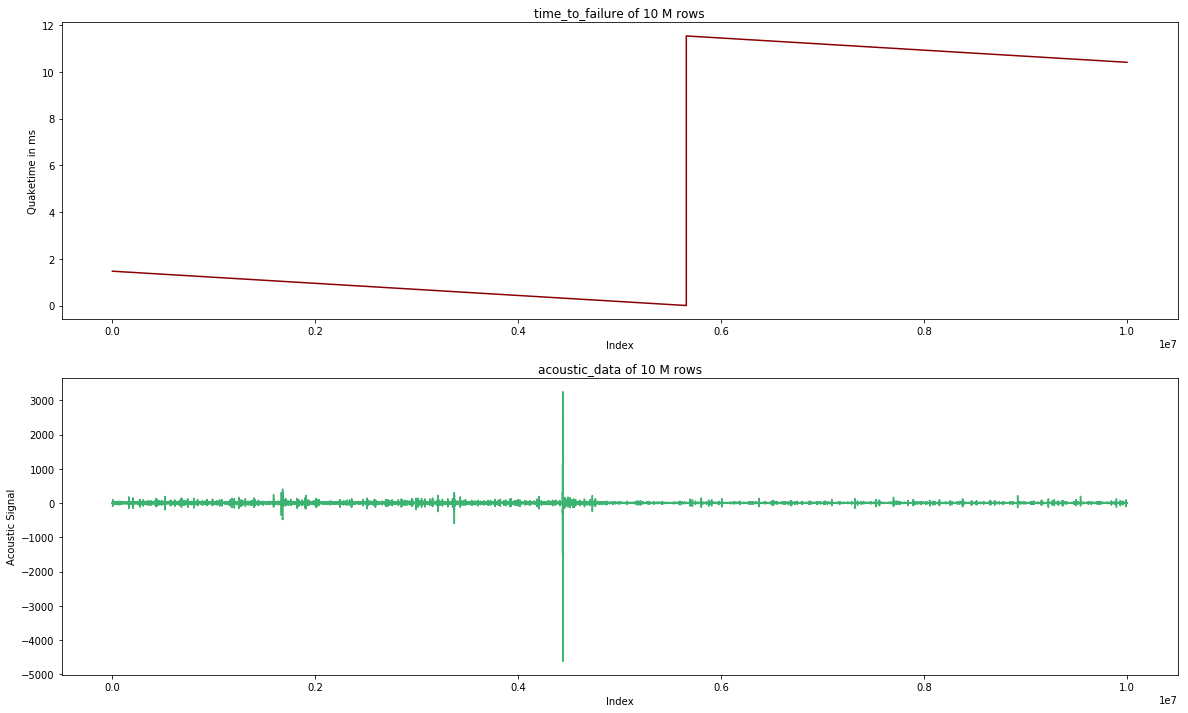

In [24]:
fig, ax = plt.subplots(2,1, figsize=(20,12))
ax[0].plot(df_train_samall.index, df_train_samall.time_to_failure, c="darkred")
ax[0].set_title("time_to_failure of 10 M rows")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Quaketime in ms");
ax[1].plot(df_train_samall.index, df_train_samall.acoustic_data, c="mediumseagreen")
ax[1].set_title("acoustic_data of 10 M rows")
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Acoustic Signal");

In [27]:
import gc
gc.collect()

40758008

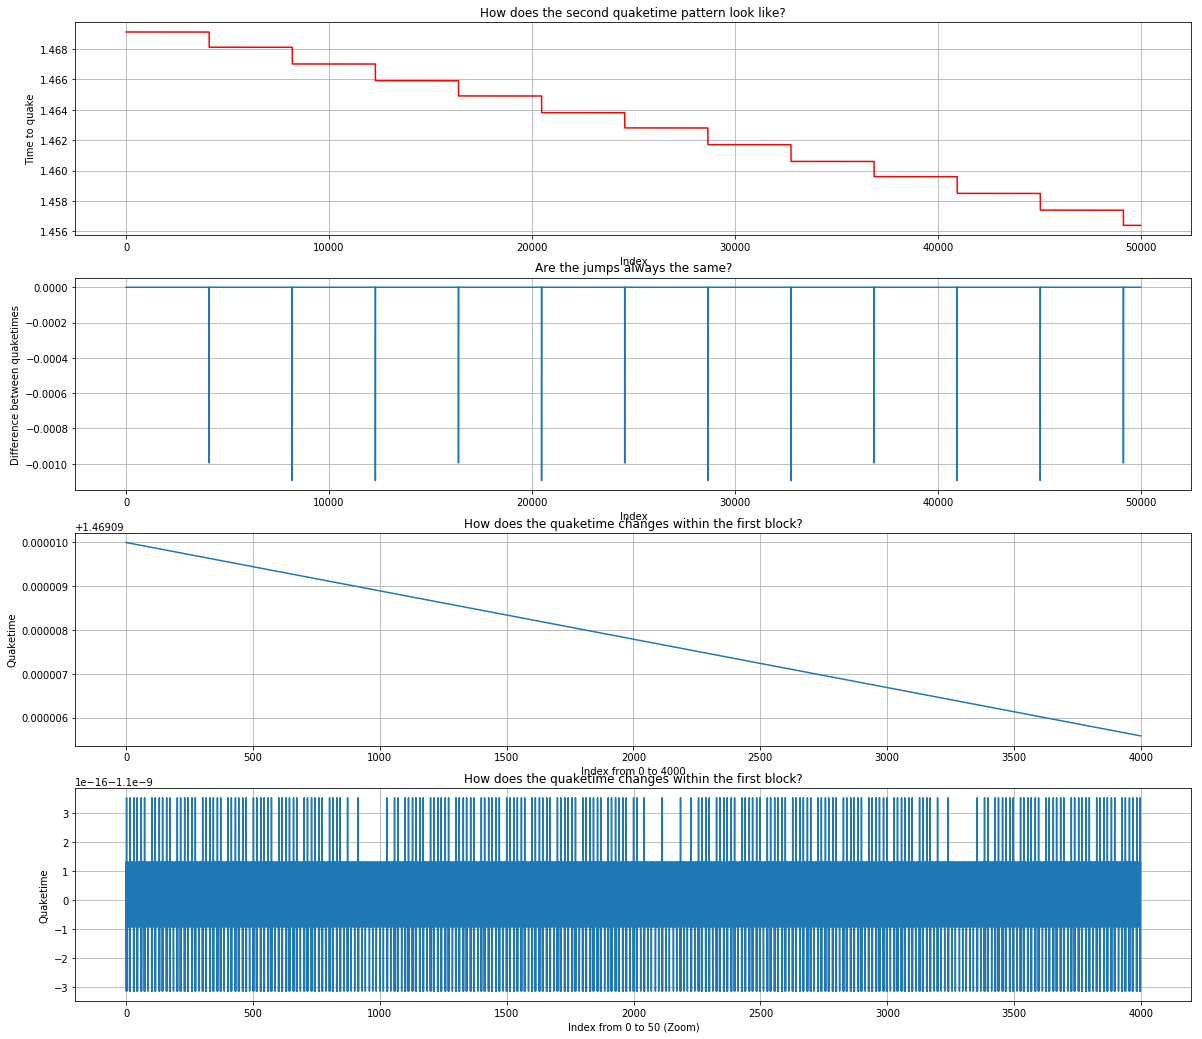

In [26]:
fig, ax = plt.subplots(4,1,figsize=(20,18))
ax[0].plot(df_train_samall.index.values[0:50000], df_train_samall.time_to_failure.values[0:50000], c="Red")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Time to quake")
ax[0].set_title("How does the second quaketime pattern look like?")
ax[0].grid()
ax[1].plot(df_train_samall.index.values[0:49999], np.diff(df_train_samall.time_to_failure.values[0:50000]))
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Difference between quaketimes")
ax[1].set_title("Are the jumps always the same?")
ax[1].grid()
ax[2].plot(df_train_samall.index.values[0:4000], df_train_samall.time_to_failure.values[0:4000])
ax[2].set_xlabel("Index from 0 to 4000")
ax[2].set_ylabel("Quaketime")
ax[2].set_title("How does the quaketime changes within the first block?");
ax[2].grid()
ax[3].plot(df_train_samall.index.values[0:3999], np.diff(df_train_samall.time_to_failure.values[0:4000]))
ax[3].set_xlabel("Index from 0 to 50 (Zoom)")
ax[3].set_ylabel("Quaketime")
ax[3].set_title("How does the quaketime changes within the first block?");
ax[3].grid()

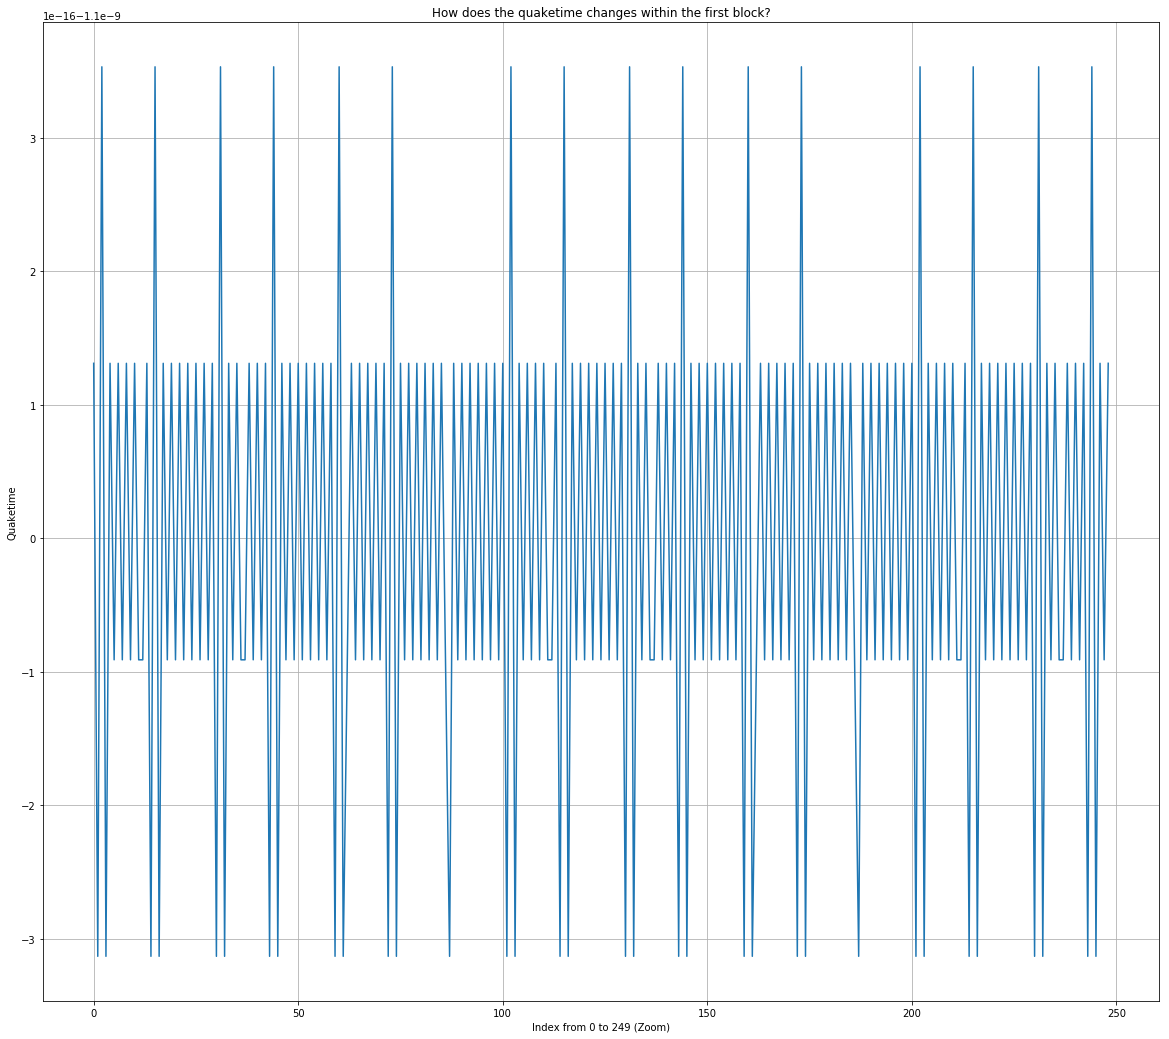

In [27]:
# See actual sample time
fig, ax = plt.subplots(1,1,figsize=(20,18))
ax.plot(df_train_samall.index.values[0:249], np.diff(df_train_samall.time_to_failure.values[0:250]))
ax.set_xlabel("Index from 0 to 249 (Zoom)")
ax.set_ylabel("Quaketime")
ax.set_title("How does the quaketime changes within the first block?");
ax.grid()

Time Domain Features Creation

In [63]:
# import pdb

def get_time_domain_features(segment_df) -> dict:
    time_domain_features = dict()
    x = pd.Series(segment_df.acoustic_data.values)
    
    time_domain_features['mean'] = x.mean()
    time_domain_features['std'] = x.std()
    time_domain_features['max'] = x.max()
    time_domain_features['min'] = x.min()
    
    
    time_domain_features[ 'mean_change_abs'] = np.mean(np.diff(x))
#     pdb.set_trace()
    time_domain_features[ 'mean_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    time_domain_features[ 'abs_max'] = np.abs(x).max()
    time_domain_features[ 'abs_min'] = np.abs(x).min()
    
    time_domain_features[ 'std_first_50000'] = x[:50000].std()
    time_domain_features[ 'std_last_50000'] = x[-50000:].std()
    time_domain_features[ 'std_first_10000'] = x[:10000].std()
    time_domain_features[ 'std_last_10000'] = x[-10000:].std()
    
    time_domain_features[ 'avg_first_50000'] = x[:50000].mean()
    time_domain_features[ 'avg_last_50000'] = x[-50000:].mean()
    time_domain_features[ 'avg_first_10000'] = x[:10000].mean()
    time_domain_features[ 'avg_last_10000'] = x[-10000:].mean()
    
    time_domain_features[ 'min_first_50000'] = x[:50000].min()
    time_domain_features[ 'min_last_50000'] = x[-50000:].min()
    time_domain_features[ 'min_first_10000'] = x[:10000].min()
    time_domain_features[ 'min_last_10000'] = x[-10000:].min()
    
    time_domain_features[ 'max_first_50000'] = x[:50000].max()
    time_domain_features[ 'max_last_50000'] = x[-50000:].max()
    time_domain_features[ 'max_first_10000'] = x[:10000].max()
    time_domain_features[ 'max_last_10000'] = x[-10000:].max()
    
    time_domain_features[ 'max_to_min'] = x.max() / np.abs(x.min())
    time_domain_features[ 'max_to_min_diff'] = x.max() - np.abs(x.min())
    time_domain_features[ 'count_big'] = len(x[np.abs(x) > 500])
    time_domain_features[ 'sum'] = x.sum()
    
    time_domain_features[ 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(x[:50000]) / x[:50000][:-1]))[0])
    time_domain_features[ 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(x[-50000:]) / x[-50000:][:-1]))[0])
    time_domain_features[ 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(x[:10000]) / x[:10000][:-1]))[0])
    time_domain_features[ 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(x[-10000:]) / x[-10000:][:-1]))[0])
    
    time_domain_features[ 'q95'] = np.quantile(x, 0.95)
    time_domain_features[ 'q99'] = np.quantile(x, 0.99)
    time_domain_features[ 'q05'] = np.quantile(x, 0.05)
    time_domain_features[ 'q01'] = np.quantile(x, 0.01)
    
    time_domain_features[ 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    time_domain_features[ 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    time_domain_features[ 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    time_domain_features[ 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    time_domain_features[ 'trend'] = add_trend_feature(x)
    time_domain_features[ 'abs_trend'] = add_trend_feature(x, abs_values=True)
    time_domain_features[ 'abs_mean'] = np.abs(x).mean()
    time_domain_features[ 'abs_std'] = np.abs(x).std()
    
    time_domain_features[ 'mad'] = x.mad()
    time_domain_features[ 'kurt'] = x.kurtosis()
    time_domain_features[ 'skew'] = x.skew()
    time_domain_features[ 'med'] = x.median()
    
    time_domain_features[ 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    time_domain_features[ 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    time_domain_features[ 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    time_domain_features[ 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    time_domain_features[ 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    time_domain_features[ 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    time_domain_features[ 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    time_domain_features[ 'Moving_average_1500_mean'] = x.rolling(window=1500).mean().mean(skipna=True)
    time_domain_features[ 'Moving_average_3000_mean'] = x.rolling(window=3000).mean().mean(skipna=True)
    time_domain_features[ 'Moving_average_6000_mean'] = x.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    time_domain_features[ 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    time_domain_features[ 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    time_domain_features[ 'exp_Moving_average_30000_mean'] = ewma(x, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    time_domain_features[ 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    time_domain_features['MA_700MA_BB_high_mean'] = np.mean(time_domain_features[ 'Moving_average_700_mean'] + no_of_std * time_domain_features[ 'MA_700MA_std_mean'])
    time_domain_features['MA_700MA_BB_low_mean'] = np.mean(time_domain_features[ 'Moving_average_700_mean'] - no_of_std * time_domain_features[ 'MA_700MA_std_mean'])
    time_domain_features[ 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    time_domain_features['MA_400MA_BB_high_mean'] = np.mean(time_domain_features[ 'Moving_average_700_mean'] + no_of_std * time_domain_features[ 'MA_400MA_std_mean'])
    time_domain_features['MA_400MA_BB_low_mean'] = np.mean(time_domain_features[ 'Moving_average_700_mean'] - no_of_std * time_domain_features[ 'MA_400MA_std_mean'])
    time_domain_features[ 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    
    time_domain_features[ 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    time_domain_features[ 'q999'] = np.quantile(x,0.999)
    time_domain_features[ 'q001'] = np.quantile(x,0.001)
    time_domain_features[ 'ave10'] = stats.trim_mean(x, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        time_domain_features[ 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        time_domain_features[ 'std_roll_std_' + str(windows)] = x_roll_std.std()
        time_domain_features[ 'max_roll_std_' + str(windows)] = x_roll_std.max()
        time_domain_features[ 'min_roll_std_' + str(windows)] = x_roll_std.min()
        time_domain_features[ 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        time_domain_features[ 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        time_domain_features[ 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        time_domain_features[ 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        time_domain_features[ 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        time_domain_features[ 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        time_domain_features[ 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        time_domain_features[ 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        time_domain_features[ 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        time_domain_features[ 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        time_domain_features[ 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        time_domain_features[ 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        time_domain_features[ 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        time_domain_features[ 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        time_domain_features[ 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        time_domain_features[ 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        time_domain_features[ 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        time_domain_features[ 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
    
#     return {key: [value] for key, value in time_domain_features.items()}
    return time_domain_features

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

In [64]:
get_time_domain_features(train_segments_no_overlap_small[0])

{'mean': 4.663633333333333,
 'std': 6.441227165295304,
 'max': 175,
 'min': -202,
 'mean_change_abs': 0.0,
 'mean_change_rate': 75001.9526532583,
 'abs_max': 202,
 'abs_min': 0,
 'std_first_50000': 5.152097909187802,
 'std_last_50000': 7.219657775183517,
 'std_first_10000': 7.500974884134811,
 'std_last_10000': 4.465342379734932,
 'avg_first_50000': 4.52642,
 'avg_last_50000': 4.59972,
 'avg_first_10000': 4.5735,
 'avg_last_10000': 4.4056,
 'min_first_50000': -56,
 'min_last_50000': -74,
 'min_first_10000': -56,
 'min_last_10000': -23,
 'max_first_50000': 66,
 'max_last_50000': 71,
 'max_first_10000': 66,
 'max_last_10000': 34,
 'max_to_min': 0.86633664,
 'max_to_min_diff': -27,
 'count_big': 0,
 'sum': 699545,
 'mean_change_rate_first_50000': 24926.002670770904,
 'mean_change_rate_last_50000': 24955.20854481063,
 'mean_change_rate_first_10000': 4979.582384460818,
 'mean_change_rate_last_10000': 4985.499546998867,
 'q95': 12.0,
 'q99': 23.0,
 'q05': -3.0,
 'q01': -14.0,
 'abs_q95': 13.

FFT Experiments

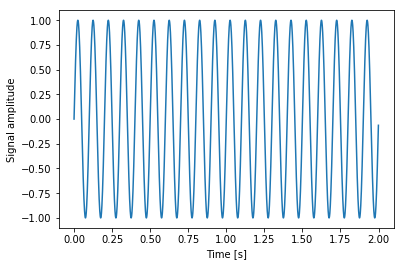

In [175]:
from scipy import fftpack

f = 10  # Frequency, in cycles per second, or Hertz
f_s = 1000  # Sampling rate, or number of measurements per second

t = np.linspace(0, 2, 2 * f_s, endpoint=False)
x = np.sin(f * 2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, x)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal amplitude');

In [16]:
def get_spectrogram_features(sig, time_spacing, f_s) -> dict:
    features = dict()
    freqs, time_bins, spectrogram = signal.spectrogram(sig, fs=f_s, nperseg=256)
    
    for time_idx, time_bin in enumerate(time_bins):
        if time_idx is not 0 and time_bin - last_time_processed < time_spacing:
            continue
            
        last_time_processed = time_bin
        psd_max_value_idx = spectrogram[:, time_idx].argmax()
        features[f"Spectrogram_max_value_in_{time_bin}_s"] = spectrogram[psd_max_value_idx, time_idx]
        features[f"Spectrogram_max_freq_in_{time_bin}_s"] = freqs[psd_max_value_idx]
    
    return features

def get_psd_features(sig, f_s) -> dict:
    features = dict()
    freqs, psd = signal.welch(x, fs=f_s, nperseg=256)
    psd_max_idx = psd.argmax()
    features['PSD_peak_value'] = psd[psd_max_idx]
    features['PSD_peak_freq'] = freqs[psd_max_idx]
    
    return features

def get_fourier_features(signal, f_s) -> dict:
    features = dict()
    fft_X = fftpack.fft(signal)
    fft_freqs = fftpack.fftfreq(len(signal), d=1/f_s)
    spectrum = np.abs(fft_X)
    
    peak_fft = spectrum.max()
    features['max_fft_amplitude'] = peak_fft
    features['max_freq'] = fft_freqs[spectrum.argmax()]
    features['fft_mean'] = spectrum.mean()
    
    spectrum_10_to_20 = spectrum[(fft_freqs >= 10) & (fft_freqs < 20)]
    features['max_amplitude_for_10Hz_to_20Hz'] = spectrum_10_to_20.max()
    features['mean_amplitude_for_10Hz_to_20Hz'] = spectrum_10_to_20.mean()
    spectrum_20_to_30 = spectrum[(fft_freqs >= 20) & (fft_freqs < 30)]
    features['max_amplitude_for_20Hz_to_30Hz'] = spectrum_20_to_30.max()
    features['mean_amplitude_for_20Hz_to_30Hz'] = spectrum_20_to_30.mean()
    
    rms_fft = np.sqrt(np.mean(spectrum**2))
    features['rms_fft'] = np.sqrt(np.mean(spectrum**2))
    features['fft_peak_rms_ratio'] = peak_fft/rms_fft
    features['fft_energy'] = np.sum(spectrum ** 2)/len(spectrum)
    
    spectrogram_features = get_spectrogram_features(signal, time_spacing=0.4, f_s=f_s)
    features.update(spectrogram_features)
    
    psd_features = get_psd_features(signal, f_s)
    features.update(psd_features)
    
    return features

In [71]:
def get_frequency_domain_features(segment_df, sampling_freq) -> dict:
    signal = segment_df.acoustic_data.values
    
    return get_fourier_features(signal, sampling_freq)

In [178]:
get_fourier_features(x, f_s)

{'max_fft_amplitude': 1000.0,
 'max_freq': 10.0,
 'fft_mean': 1.0000000000000755,
 'max_amplitude_for_10Hz_to_20Hz': 1000.0,
 'mean_amplitude_for_10Hz_to_20Hz': 50.0000000000002,
 'max_amplitude_for_20Hz_to_30Hz': 3.2236683383129466e-13,
 'mean_amplitude_for_20Hz_to_30Hz': 1.1261856414957185e-13,
 'rms_fft': 31.622776601683793,
 'fft_peak_rms_ratio': 31.622776601683793,
 'fft_energy': 1000.0,
 'Spectrogram_max_value_in_0.128_s': 0.0676955224164064,
 'Spectrogram_max_freq_in_0.128_s': 11.71875,
 'Spectrogram_max_value_in_0.576_s': 0.06776278994099409,
 'Spectrogram_max_freq_in_0.576_s': 11.71875,
 'Spectrogram_max_value_in_1.024_s': 0.06777951516200093,
 'Spectrogram_max_freq_in_1.024_s': 11.71875,
 'Spectrogram_max_value_in_1.472_s': 0.06774464717227989,
 'Spectrogram_max_freq_in_1.472_s': 11.71875,
 'PSD_peak_value': 0.06626918416182985,
 'PSD_peak_freq': 11.71875}

Text(0.5, 0, 'Time [sec]')

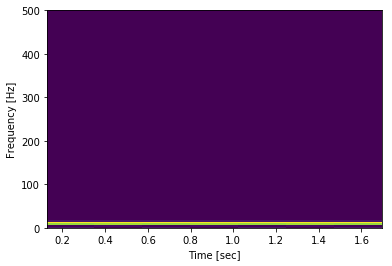

In [138]:
f, t, Sxx = signal.spectrogram(x, fs=f_s, window='hanning',
                                              nperseg=256)

# plt.figure(figsize=(5, 4))
# plt.imshow(spectrogram, aspect='auto', cmap='hot_r', origin='lower')
# plt.title('Spectrogram')
# plt.ylabel('Frequency band')
# plt.xlabel('Time window')
# plt.tight_layout()
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

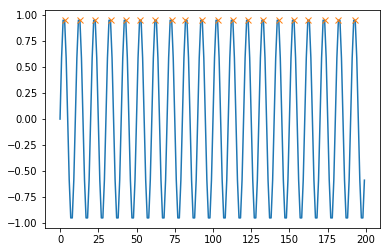

In [59]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(x, height=0)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")

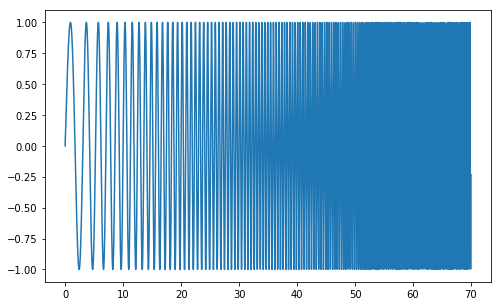

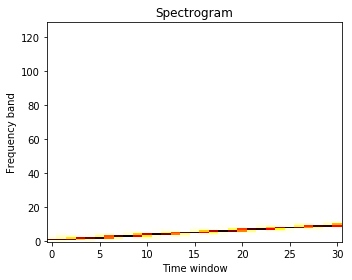

In [114]:
# Seed the random number generator
np.random.seed(0)

time_step = .01
time_vec = np.arange(0, 70, time_step)

# A signal with a small frequency chirp
sig = np.sin(0.5 * np.pi * time_vec * (1 + .1 * time_vec))

plt.figure(figsize=(8, 5))
plt.plot(time_vec, sig)

from scipy import signal

freqs, times, spectrogram = signal.spectrogram(sig, fs=1/time_step)

plt.figure(figsize=(5, 4))
plt.imshow(spectrogram, aspect='auto', cmap='hot_r', origin='lower')
plt.title('Spectrogram')
plt.ylabel('Frequency band')
plt.xlabel('Time window')
plt.tight_layout()

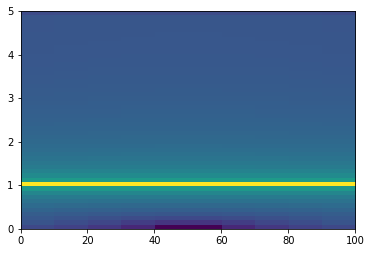

In [72]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np

t = np.linspace(0,100,1000)
omega = 2*np.pi*1
y = np.sin(omega*t)

spacing = t[1] - t[0]
plt.specgram(y,NFFT=100,noverlap=0,Fs=1./spacing,window=mlab.window_none)
plt.show()

(-5, 110)

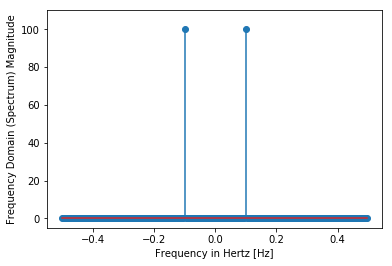

In [30]:
X = fftpack.fft(x)
freqs = fftpack.fftfreq(len(x), d=1)# * f_s

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(X))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
# ax.set_xlim(-f_s / 2, f_s / 2)
ax.set_ylim(-5, 110)

Train set creation from given segments

In [65]:
SAMPLING_FREQ = 4000000

def create_train_set(list_of_raw_segments) -> pd.DataFrame:
    train_set = pd.DataFrame()
    
    for segment_idx, raw_segment_df in enumerate(tqdm(list_of_raw_segments)):
        target = raw_segment_df.time_to_failure.values[-1]
        train_set.loc[segment_idx, 'target'] = target
        # Features creation
        time_domain_features = get_time_domain_features(raw_segment_df)
        add_features_to_df(train_set, time_domain_features, segment_idx)
        
#         frequency_domain_features = get_frequency_domain_features(raw_segment_df, SAMPLING_FREQ)
#         add_features_to_df(train_set, frequency_domain_features, segment_idx)
    
    return train_set

def add_features_to_df(df: pd.DataFrame, features: dict, idx: int) -> None:
    for feature_name, feature_value in features.items():
        df.loc[idx, feature_name] = feature_value

In [70]:
a = create_train_set(training_segments_no_overlap)
a.head()

100%|██████████| 4178/4178 [17:56<00:00,  4.05it/s]


,target,mean,std,max,min,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,1.430797,4.884113,5.101106,104.0,-98.0,-0.000080,74836.577199,104.0,0.0,6.488552,...,0.295715,5.629,3.896,4.072,4.379,5.338,5.484,-0.000002,74222.343443,5.629
1,1.391499,4.725767,6.588824,181.0,-154.0,0.000000,74891.736232,181.0,0.0,7.305233,...,0.231587,5.667,3.412,4.233,4.345,5.066,5.223,-0.000002,74364.426478,5.667
2,1.353196,4.906393,6.967397,140.0,-106.0,-0.000013,75099.224451,140.0,0.0,6.104836,...,0.267012,5.957,4.055,4.239,4.446,5.344,5.486,0.000001,74594.984584,5.957
3,1.313798,4.902240,6.922305,197.0,-199.0,0.000000,74933.991879,199.0,0.0,6.238109,...,0.266700,5.858,3.722,4.304,4.433,5.317,5.453,-0.000003,74333.143623,5.858
4,1.274400,4.908720,7.301110,145.0,-126.0,-0.000007,75010.016046,145.0,0.0,5.323830,...,0.228005,6.078,3.918,4.434,4.543,5.306,5.491,0.000002,74428.435969,6.078


In [73]:
path = data_path/'train'/'processed_df'
path.mkdir()
a.to_csv(path/'no_overlap_only_time_features.csv')

In [8]:
print(f"Train length: {len(df_train)}")
print(f"Test length: {len(df_test)}")

Train length: 200000
Test length: 200000


In [122]:
# ID_code won't be used as a feature
df_train = df_train_original.drop(['ID_code'], axis=1)
df_test = df_test_original.drop(['ID_code'], axis=1)

Test dataset is a conjunction of real and synthetic (created based on a real) samples.

More details about this discovery in:
https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split

In [68]:
# Discover real and synthetic samples
test_dataset = df_test.values

unique_samples = list()
unique_count = np.zeros_like(test_dataset)

for feature_nbr in trange(test_dataset.shape[1]):
    feature_values = test_dataset[:, feature_nbr]
    _, index, count = np.unique(feature_values, return_counts=True, return_index=True)
    unique_count[index[count == 1], feature_nbr] += 1

# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print(f"Found {len(real_samples_indexes)} real test samples")
print(f"Found {len(synthetic_samples_indexes)} synthetic test samples")

100%|██████████| 200/200 [00:05<00:00, 35.33it/s]


Found 100000 real test samples
Found 100000 synthetic test samples


We will use LightGBM as a model to predict target for test dataset. This is a tree-based model, which cannot see frequency of the feature (number of occurrences of particular value in a feature). It turns out that this is important in this case, so frequencies needs to be added as separate feature. 

In [69]:
# Combine both train and test dataset but use only real test samples
df_combined_train_test = pd.concat([df_train.drop(['target'], axis=1), df_test.loc[real_samples_indexes]], axis=0, sort=True)

# To each feature add new feature which corresponds to nbr of occurrences of this feature in combined dataset
for feature_name in tqdm(df_combined_train_test.columns):
    feature_freq = df_combined_train_test[feature_name].value_counts()
    new_feature_name = f"{feature_name}_freq"
    df_train[new_feature_name] = df_train[feature_name].map(feature_freq)
    df_test[new_feature_name] = df_test[feature_name].map(feature_freq)

100%|██████████| 200/200 [00:09<00:00, 22.15it/s]


# Model Training
## 1st Layer of ensamble

In [87]:
param = {
    'learning_rate': 0.04,
    'num_leaves': 3,
    'metric':'auc',
    'boost_from_average':'false',
    'feature_fraction': 1.0, # This is important; we must use ALL features in every iteration to make sure that feature freq will be used
    'max_depth': -1,
    'objective': 'binary',
    'verbosity': -10
}

In [98]:
%%time

nbr_of_original_features = 200
nbr_of_folds = 5
nbr_of_rounds = 750

folds = StratifiedKFold(
    n_splits=nbr_of_folds,
    shuffle=True,
    random_state=2019
)

out_of_fold_predictions = np.zeros((len(df_train), nbr_of_original_features))
test_predictions = np.zeros((len(df_test), nbr_of_original_features))

train_data = df_train.drop('target', axis=1)
targets = df_train['target']

for feature_nbr in range(nbr_of_original_features):
    print(f"Processing feature {feature_nbr}/{nbr_of_original_features}")
    # Use only original feature and frequencies of this feature 
    features = [f"var_{feature_nbr}", f"var_{feature_nbr}_freq"]
    
    folds_predictions = np.zeros(len(df_test))
    training_results = dict()
    
    for fold_nbr, (train_idx, valid_idx) in enumerate(folds.split(train_data, targets)):
        fold_train_data = train_data[features].iloc[train_idx]
        fold_train_target = targets.iloc[train_idx]
        
        fold_valid_data = train_data[features].iloc[valid_idx]
        fold_valid_target = targets.iloc[valid_idx]

        lgb_fold_train = lgb.Dataset(fold_train_data, label=fold_train_target)
        lgb_fold_valid = lgb.Dataset(fold_valid_data, label=fold_valid_target, reference=lgb_fold_train)

        model = lgb.train(
            param, 
            lgb_fold_train, 
            nbr_of_rounds, 
            valid_sets=[lgb_fold_train, lgb_fold_valid], 
#             early_stopping_rounds=500,
            verbose_eval=False, 
            evals_result=training_results
#             verbose_eval=1000
        )
        
        scores = training_results['valid_1']['auc']
        best_score = max(scores)
        best_round = scores.index(max(scores))
        print(f"Fold #{fold_nbr}: Best auc: {best_score} ({best_round} iteration)")

        out_of_fold_predictions[valid_idx, feature_nbr] = model.predict(fold_valid_data, num_iteration=best_round)
        folds_predictions += model.predict(df_test, num_iteration=best_round)

    test_predictions[:, feature_nbr] = folds_predictions/nbr_of_folds

    print(f"Final feature auc score: {roc_auc_score(targets, out_of_fold_predictions[:, feature_nbr])}")
    print("-" * 20)

Processing feature 0/200
Fold #0: Best auc: 0.5416882300097301 (464 iteration)
Fold #1: Best auc: 0.5486695852883107 (106 iteration)
Fold #2: Best auc: 0.5566815208283209 (229 iteration)
Fold #3: Best auc: 0.5451479361305063 (165 iteration)
Fold #4: Best auc: 0.5514666783583979 (278 iteration)
Final feature auc score: 0.5466116484750508
--------------------
Processing feature 1/200
Fold #0: Best auc: 0.5519179933411512 (188 iteration)
Fold #1: Best auc: 0.553960143558354 (202 iteration)
Fold #2: Best auc: 0.5398148778066311 (164 iteration)
Fold #3: Best auc: 0.5438991983741486 (267 iteration)
Fold #4: Best auc: 0.5443476691662352 (252 iteration)
Final feature auc score: 0.5459670911053918
--------------------
Processing feature 2/200
Fold #0: Best auc: 0.5462121523230682 (237 iteration)
Fold #1: Best auc: 0.5587087733285436 (271 iteration)
Fold #2: Best auc: 0.5504921404649902 (172 iteration)
Fold #3: Best auc: 0.5481189647949339 (159 iteration)
Fold #4: Best auc: 0.5545247760740706 (3

Fold #0: Best auc: 0.5202315076185179 (187 iteration)
Fold #1: Best auc: 0.5249154957543236 (192 iteration)
Fold #2: Best auc: 0.5255242029153842 (68 iteration)
Fold #3: Best auc: 0.526682928131398 (165 iteration)
Fold #4: Best auc: 0.5248938546628362 (120 iteration)
Final feature auc score: 0.5179572344514115
--------------------
Processing feature 24/200
Fold #0: Best auc: 0.5238930586775967 (2 iteration)
Fold #1: Best auc: 0.5311106774014643 (194 iteration)
Fold #2: Best auc: 0.5348139963052995 (179 iteration)
Fold #3: Best auc: 0.529849297687015 (663 iteration)
Fold #4: Best auc: 0.5251476069547913 (749 iteration)
Final feature auc score: 0.5196775647964788
--------------------
Processing feature 25/200
Fold #0: Best auc: 0.5102167347581594 (716 iteration)
Fold #1: Best auc: 0.5086061452278365 (4 iteration)
Fold #2: Best auc: 0.5144387290894057 (55 iteration)
Fold #3: Best auc: 0.5082088090187507 (78 iteration)
Fold #4: Best auc: 0.5133224707652547 (20 iteration)
Final feature auc 

Fold #0: Best auc: 0.5091463522552878 (48 iteration)
Fold #1: Best auc: 0.5044542683597105 (44 iteration)
Fold #2: Best auc: 0.5022368908652955 (12 iteration)
Fold #3: Best auc: 0.5032604750835422 (0 iteration)
Fold #4: Best auc: 0.5027952273947222 (729 iteration)
Final feature auc score: 0.5009402064147664
--------------------
Processing feature 47/200
Fold #0: Best auc: 0.5094433926639834 (369 iteration)
Fold #1: Best auc: 0.5142363866446373 (85 iteration)
Fold #2: Best auc: 0.503099856470842 (53 iteration)
Fold #3: Best auc: 0.5045736164834601 (749 iteration)
Fold #4: Best auc: 0.5079058325095872 (597 iteration)
Final feature auc score: 0.5033557103306272
--------------------
Processing feature 48/200
Fold #0: Best auc: 0.5295861614912569 (80 iteration)
Fold #1: Best auc: 0.5279623740058497 (163 iteration)
Fold #2: Best auc: 0.5396152194834609 (141 iteration)
Fold #3: Best auc: 0.5515084926642916 (452 iteration)
Fold #4: Best auc: 0.5245767049261976 (517 iteration)
Final feature auc

Fold #0: Best auc: 0.5041536536488785 (8 iteration)
Fold #1: Best auc: 0.5088348037749608 (79 iteration)
Fold #2: Best auc: 0.5085112168451793 (7 iteration)
Fold #3: Best auc: 0.513499603260278 (156 iteration)
Fold #4: Best auc: 0.5088865963383212 (84 iteration)
Final feature auc score: 0.5032579099336686
--------------------
Processing feature 70/200
Fold #0: Best auc: 0.535051466493994 (152 iteration)
Fold #1: Best auc: 0.523472134477829 (121 iteration)
Fold #2: Best auc: 0.5326693727029113 (328 iteration)
Fold #3: Best auc: 0.5183377048237106 (735 iteration)
Fold #4: Best auc: 0.52760976523271 (102 iteration)
Final feature auc score: 0.5242927340935641
--------------------
Processing feature 71/200
Fold #0: Best auc: 0.533517510139749 (124 iteration)
Fold #1: Best auc: 0.53138373127 (107 iteration)
Fold #2: Best auc: 0.5285986479498007 (210 iteration)
Fold #3: Best auc: 0.5350435694486764 (99 iteration)
Fold #4: Best auc: 0.5323458707326967 (739 iteration)
Final feature auc score: 0

Fold #0: Best auc: 0.5487059678124759 (98 iteration)
Fold #1: Best auc: 0.5423293574925738 (93 iteration)
Fold #2: Best auc: 0.5477910959377653 (233 iteration)
Fold #3: Best auc: 0.5391923175920492 (13 iteration)
Fold #4: Best auc: 0.5421921525892643 (107 iteration)
Final feature auc score: 0.5286699704748197
--------------------
Processing feature 93/200
Fold #0: Best auc: 0.529361851563173 (272 iteration)
Fold #1: Best auc: 0.535789767291499 (167 iteration)
Fold #2: Best auc: 0.5247912432003408 (78 iteration)
Fold #3: Best auc: 0.5310672028819196 (72 iteration)
Fold #4: Best auc: 0.5342352321470237 (173 iteration)
Final feature auc score: 0.5247042201631036
--------------------
Processing feature 94/200
Fold #0: Best auc: 0.5439995970786683 (573 iteration)
Fold #1: Best auc: 0.5429245133660233 (205 iteration)
Fold #2: Best auc: 0.5509732708055055 (118 iteration)
Fold #3: Best auc: 0.537483477246282 (394 iteration)
Fold #4: Best auc: 0.5448308762947982 (116 iteration)
Final feature au

Fold #0: Best auc: 0.5493535732858456 (113 iteration)
Fold #1: Best auc: 0.5407809518318195 (62 iteration)
Fold #2: Best auc: 0.5416393262979157 (327 iteration)
Fold #3: Best auc: 0.5479493182812436 (80 iteration)
Fold #4: Best auc: 0.5500843927696969 (174 iteration)
Final feature auc score: 0.5356488354531971
--------------------
Processing feature 116/200
Fold #0: Best auc: 0.5261989640469452 (124 iteration)
Fold #1: Best auc: 0.5220040434552178 (66 iteration)
Fold #2: Best auc: 0.5209651817344627 (1 iteration)
Fold #3: Best auc: 0.5189280531151295 (691 iteration)
Fold #4: Best auc: 0.5322857857915314 (240 iteration)
Final feature auc score: 0.5115128317686399
--------------------
Processing feature 117/200
Fold #0: Best auc: 0.5098412913061772 (395 iteration)
Fold #1: Best auc: 0.5134244669761445 (500 iteration)
Fold #2: Best auc: 0.5165865088122478 (89 iteration)
Fold #3: Best auc: 0.5087986524818673 (154 iteration)
Fold #4: Best auc: 0.5056118442954609 (749 iteration)
Final featur

Fold #0: Best auc: 0.521242395620353 (121 iteration)
Fold #1: Best auc: 0.5151856300333192 (286 iteration)
Fold #2: Best auc: 0.523914059496846 (217 iteration)
Fold #3: Best auc: 0.5179258479144575 (98 iteration)
Fold #4: Best auc: 0.5186174108227719 (157 iteration)
Final feature auc score: 0.5168053378336757
--------------------
Processing feature 139/200
Fold #0: Best auc: 0.5781767215173403 (341 iteration)
Fold #1: Best auc: 0.5768971732040445 (303 iteration)
Fold #2: Best auc: 0.5797014095724822 (251 iteration)
Fold #3: Best auc: 0.5628114150945875 (139 iteration)
Fold #4: Best auc: 0.578126055903718 (192 iteration)
Final feature auc score: 0.5743137778258922
--------------------
Processing feature 140/200
Fold #0: Best auc: 0.5133657813597309 (95 iteration)
Fold #1: Best auc: 0.5114693513616432 (36 iteration)
Fold #2: Best auc: 0.5184073863589225 (55 iteration)
Fold #3: Best auc: 0.5131098619799421 (26 iteration)
Fold #4: Best auc: 0.5086087125619677 (0 iteration)
Final feature au

Fold #0: Best auc: 0.5094643752693689 (64 iteration)
Fold #1: Best auc: 0.5063563916611047 (4 iteration)
Fold #2: Best auc: 0.5073366284198795 (36 iteration)
Fold #3: Best auc: 0.5054809519982971 (71 iteration)
Fold #4: Best auc: 0.5071444788173353 (338 iteration)
Final feature auc score: 0.5007857748878723
--------------------
Processing feature 162/200
Fold #0: Best auc: 0.5333543643335253 (281 iteration)
Fold #1: Best auc: 0.53224902695328 (84 iteration)
Fold #2: Best auc: 0.5405602995306956 (134 iteration)
Fold #3: Best auc: 0.5246181942056499 (210 iteration)
Fold #4: Best auc: 0.5225401964349163 (94 iteration)
Final feature auc score: 0.5252755717448975
--------------------
Processing feature 163/200
Fold #0: Best auc: 0.5372335468373924 (180 iteration)
Fold #1: Best auc: 0.531444812429335 (536 iteration)
Fold #2: Best auc: 0.5397530551799092 (112 iteration)
Fold #3: Best auc: 0.5288622615395105 (258 iteration)
Fold #4: Best auc: 0.5315617202390922 (54 iteration)
Final feature auc

Fold #0: Best auc: 0.5600685152929663 (525 iteration)
Fold #1: Best auc: 0.5521591792296128 (501 iteration)
Fold #2: Best auc: 0.5497067642609631 (243 iteration)
Fold #3: Best auc: 0.5508626409214376 (502 iteration)
Fold #4: Best auc: 0.535501708048526 (137 iteration)
Final feature auc score: 0.5488549590126964
--------------------
Processing feature 185/200
Fold #0: Best auc: 0.500334121200783 (201 iteration)
Fold #1: Best auc: 0.5064990733777266 (370 iteration)
Fold #2: Best auc: 0.5043378507683927 (14 iteration)
Fold #3: Best auc: 0.4964019261758454 (6 iteration)
Fold #4: Best auc: 0.503181590474706 (10 iteration)
Final feature auc score: 0.5006699090997564
--------------------
Processing feature 186/200
Fold #0: Best auc: 0.5322847630611015 (69 iteration)
Fold #1: Best auc: 0.5307158863972016 (69 iteration)
Fold #2: Best auc: 0.5315594968459537 (391 iteration)
Fold #3: Best auc: 0.5311601604441162 (649 iteration)
Fold #4: Best auc: 0.5268271845476621 (355 iteration)
Final feature a

In [103]:
np.save(data_path/'oof', out_of_fold_predictions)
np.save(data_path/'ensemble_1st_lvl', test_predictions)

## 2nd Layer of ensamble

In [109]:
from sklearn.linear_model import LogisticRegression

X_train, X_valid, Y_train, Y_valid = train_test_split(
    out_of_fold_predictions, 
    targets.values, 
    test_size=0.15, 
    random_state=2019
)

ensamble_second_layer = LogisticRegression(n_jobs=-1)
ensamble_second_layer.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [118]:
probs = ensamble_second_layer.predict_proba(X_valid)
roc_auc_score(Y_valid, probs[:,1])

0.9040947053429751

In [115]:
import statsmodels.api as sm

logr = sm.Logit(targets, out_of_fold_predictions)
logr = logr.fit(disp=0)
ensemble_preds = logr.predict(out_of_fold_predictions)
ensemble_auc = roc_auc_score(targets, ensemble_preds)  
print('##################')
print('Combined Model with magic Val_AUC=',round(ensemble_auc,5))

##################
Combined Model with magic Val_AUC= 0.91402


In [117]:
lgb_ensemble_train = lgb.Dataset(X_train, label=Y_train)
lgb_ensemble_valid = lgb.Dataset(X_valid, label=Y_valid, reference=lgb_ensemble_train)

model = lgb.train(
    param, 
    lgb_ensemble_train, 
    50000, 
    valid_sets=[lgb_ensemble_train, lgb_ensemble_valid], 
    early_stopping_rounds=500,
#     verbose_eval=False, 
#             evals_result=training_results
    verbose_eval=1000
    )

# ensemble_predicions = model.predict(fold_valid_data)
# folds_predictions += model.predict(df_test, num_iteration=best_round)


Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.893676	valid_1's auc: 0.878561
[2000]	training's auc: 0.912475	valid_1's auc: 0.895864
[3000]	training's auc: 0.921207	valid_1's auc: 0.902603
[4000]	training's auc: 0.926821	valid_1's auc: 0.906273
[5000]	training's auc: 0.931289	valid_1's auc: 0.908226
[6000]	training's auc: 0.935035	valid_1's auc: 0.909387
[7000]	training's auc: 0.938219	valid_1's auc: 0.910122
[8000]	training's auc: 0.94106	valid_1's auc: 0.910847
[9000]	training's auc: 0.943547	valid_1's auc: 0.911536
[10000]	training's auc: 0.945812	valid_1's auc: 0.912033
[11000]	training's auc: 0.947898	valid_1's auc: 0.912439
[12000]	training's auc: 0.949817	valid_1's auc: 0.912743
[13000]	training's auc: 0.951595	valid_1's auc: 0.912847
Early stopping, best iteration is:
[12584]	training's auc: 0.950872	valid_1's auc: 0.91289


# Final prediction and submission to Kaggle

In [119]:
predictions = model.predict(test_predictions)

In [123]:
submission_df = pd.DataFrame({'ID_code': df_test_original['ID_code'], 'target': predictions})

In [124]:
submission_df.head()

,ID_code,target
0,test_0,1.000000
1,test_1,0.999990
2,test_2,0.999898
3,test_3,0.999990
4,test_4,0.999979


In [14]:
submission_file = data_path/'submission_lgbm_augmentation.csv'
submission_df.to_csv(submission_file, index=False)

In [15]:
# Only 3 submission allowed per day!
!kaggle competitions submit {competition_name} -f {submission_file} -m "LightGBM, 11 folds,augmentation"

100%|██████████████████████████████████████| 6.03M/6.03M [00:02<00:00, 2.44MB/s]
Successfully submitted to Santander Customer Transaction Prediction